# Phase 6: V2 Multi-Class & V3 MFE Regression (Retrained)

**Goal:** Predict HOW FAR price moves (MFE) instead of binary win/loss, enabling dynamic take-profit

**Dataset:** ~98K labeled patterns across 5 types, 20 pairs, 4 timeframes with HTF context

**Models:**
- V2: Multi-class classifier on MFE buckets [<0.5R, 0.5-1R, 1-1.5R, 1.5-2R, 2R+]
- V3: Regression on continuous MFE value
- Dynamic TP: Set take-profit at 80% of predicted MFE

In [1]:
# Cell 1: Load Data & Create MFE Bucket Labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 120

CSV_PATH = "/Users/muftau/Documents/programming/trading-ai/python/data/training-all.csv"

df_raw = pd.read_csv(CSV_PATH, low_memory=False)
df_raw = df_raw[df_raw["outcome"].isin(["win", "loss"])].reset_index(drop=True)
print(f"Dataset: {len(df_raw)} rows")

df = df_raw.copy()

# Drop always-null columns
null_pct = df.isnull().mean()
always_null = null_pct[null_pct > 0.99].index.tolist()
if always_null:
    print(f"Dropping always-null columns: {always_null}")
    df = df.drop(columns=always_null)

metadata_cols = [
    "id", "pair", "start_timestamp", "end_timestamp",
    "entry_price", "stop_loss", "take_profit", "notes",
    "nearest_round_number", "nearest_support", "nearest_resistance",
]
analysis_only_cols = ["outcome", "r_multiple", "bars_to_outcome", "max_favorable_excursion"]

# Encode categoricals
categorical_cols = ["pattern_type", "timeframe", "trend_state", "trading_session", "rsi_zone"]
htf_trend_cols = [c for c in df.columns if c.endswith("_trend_state") and c.startswith("htf_")]
categorical_cols.extend(htf_trend_cols)

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

df_raw["trend_state"] = df_raw["trend_state"].fillna("unknown")
df_raw["trading_session"] = df_raw["trading_session"].fillna("unknown")

df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], dtype=int)

drop_cols = metadata_cols + analysis_only_cols + ["quality_rating"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
mfe = df_raw["max_favorable_excursion"].values

# --- MFE bucket labels for V2 ---
bucket_edges = [0, 0.5, 1.0, 1.5, 2.0, np.inf]
bucket_labels = ["<0.5R", "0.5-1R", "1-1.5R", "1.5-2R", "2R+"]
mfe_buckets = pd.cut(mfe, bins=bucket_edges, labels=bucket_labels, right=False)
y_v2 = mfe_buckets.codes

# --- Binary target for V1b comparison ---
y_v1 = (df_raw["outcome"] == "win").astype(int).values

# --- Continuous MFE target for V3 ---
y_v3 = mfe

print(f"Features: {X.shape[1]}")
print(f"\nMFE bucket distribution:")
for i, label in enumerate(bucket_labels):
    count = (y_v2 == i).sum()
    print(f"  {label:8s}: {count:5d} ({count/len(y_v2):.1%})")

# --- Time-based split ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_v1_train, y_v1_test = y_v1[:split_idx], y_v1[split_idx:]
y_v2_train, y_v2_test = y_v2[:split_idx], y_v2[split_idx:]
y_v3_train, y_v3_test = y_v3[:split_idx], y_v3[split_idx:]
mfe_test = mfe[split_idx:]
df_test = df_raw.iloc[split_idx:].copy()

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

Dataset: 96565 rows
Features: 104

MFE bucket distribution:
  <0.5R   : 49020 (50.8%)
  0.5-1R  : 19392 (20.1%)
  1-1.5R  : 10648 (11.0%)
  1.5-2R  :  2847 (2.9%)
  2R+     : 14658 (15.2%)

Train: 77252 | Test: 19313


=== V2 Multi-Class Performance ===
Accuracy: 0.452

              precision    recall  f1-score   support

       <0.5R       0.77      0.33      0.46      7798
      0.5-1R       0.35      0.41      0.38      3655
      1-1.5R       0.15      0.06      0.08      1931
      1.5-2R       0.08      0.14      0.10       829
         2R+       0.47      0.86      0.61      5100

    accuracy                           0.45     19313
   macro avg       0.36      0.36      0.33     19313
weighted avg       0.52      0.45      0.43     19313



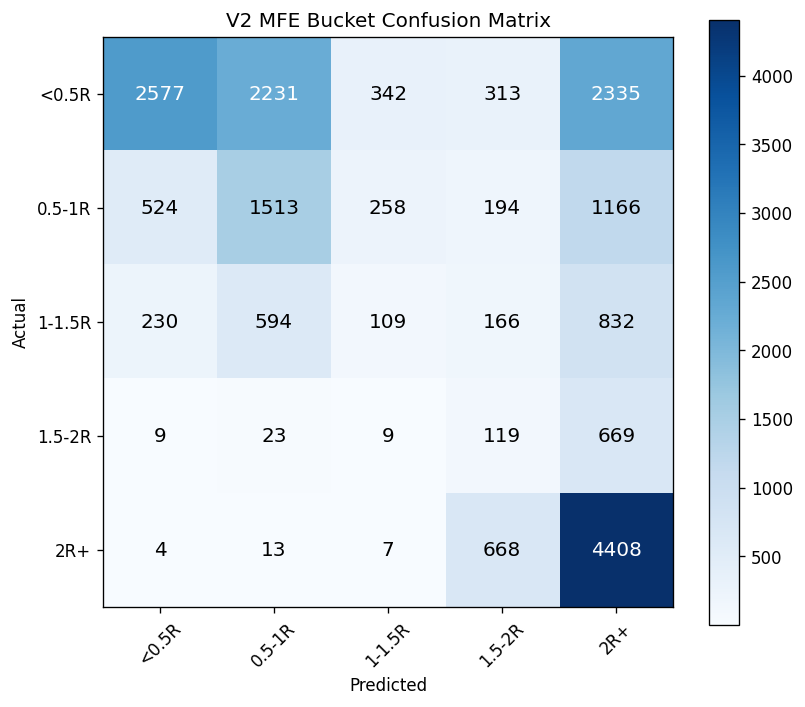


High-MFE detection (>= 1.5R):
  Predicted high: 10870 / 19313
  Precision: 0.539
  Recall: 0.989


In [2]:
# Cell 2: V2 — Multi-Class XGBoost on MFE Buckets
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score,
)

# Train V1b baseline for comparison
spw_v1 = (len(y_v1_train) - y_v1_train.sum()) / max(y_v1_train.sum(), 1)
model_v1 = xgb.XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    scale_pos_weight=spw_v1, eval_metric="logloss",
    random_state=42, enable_categorical=False,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
)
model_v1.fit(X_train, y_v1_train)

# Train V2 multi-class
class_counts = np.bincount(y_v2_train, minlength=5)
class_weights = len(y_v2_train) / (5 * np.maximum(class_counts, 1))
sample_weights_train = class_weights[y_v2_train]

model_v2 = xgb.XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    objective="multi:softprob", num_class=5,
    eval_metric="mlogloss", random_state=42,
    enable_categorical=False,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
)
model_v2.fit(X_train, y_v2_train, sample_weight=sample_weights_train)

y_v2_pred = model_v2.predict(X_test)
y_v2_prob = model_v2.predict_proba(X_test)

print("=== V2 Multi-Class Performance ===")
print(f"Accuracy: {accuracy_score(y_v2_test, y_v2_pred):.3f}")
print(f"\n{classification_report(y_v2_test, y_v2_pred, target_names=bucket_labels, zero_division=0)}")

# Confusion matrix
cm = confusion_matrix(y_v2_test, y_v2_pred)
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(bucket_labels, rotation=45)
ax.set_yticklabels(bucket_labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("V2 MFE Bucket Confusion Matrix")
for i in range(5):
    for j in range(5):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=12)
plt.colorbar(im)
plt.tight_layout()
plt.show()

# High-MFE detection
pred_high = y_v2_pred >= 3  # predicted 1.5R+
actual_high = y_v2_test >= 3
if pred_high.sum() > 0:
    print(f"\nHigh-MFE detection (>= 1.5R):")
    print(f"  Predicted high: {pred_high.sum()} / {len(pred_high)}")
    print(f"  Precision: {(pred_high & actual_high).sum() / max(pred_high.sum(), 1):.3f}")
    print(f"  Recall: {(pred_high & actual_high).sum() / max(actual_high.sum(), 1):.3f}")
else:
    print(f"\nV2 predicted no trades >= 1.5R (actual: {actual_high.sum()})")

=== V3 Regression Performance ===
MAE:  0.635R
RMSE: 0.940R
R²:   0.394

Baseline MAE (predict mean): 0.873R


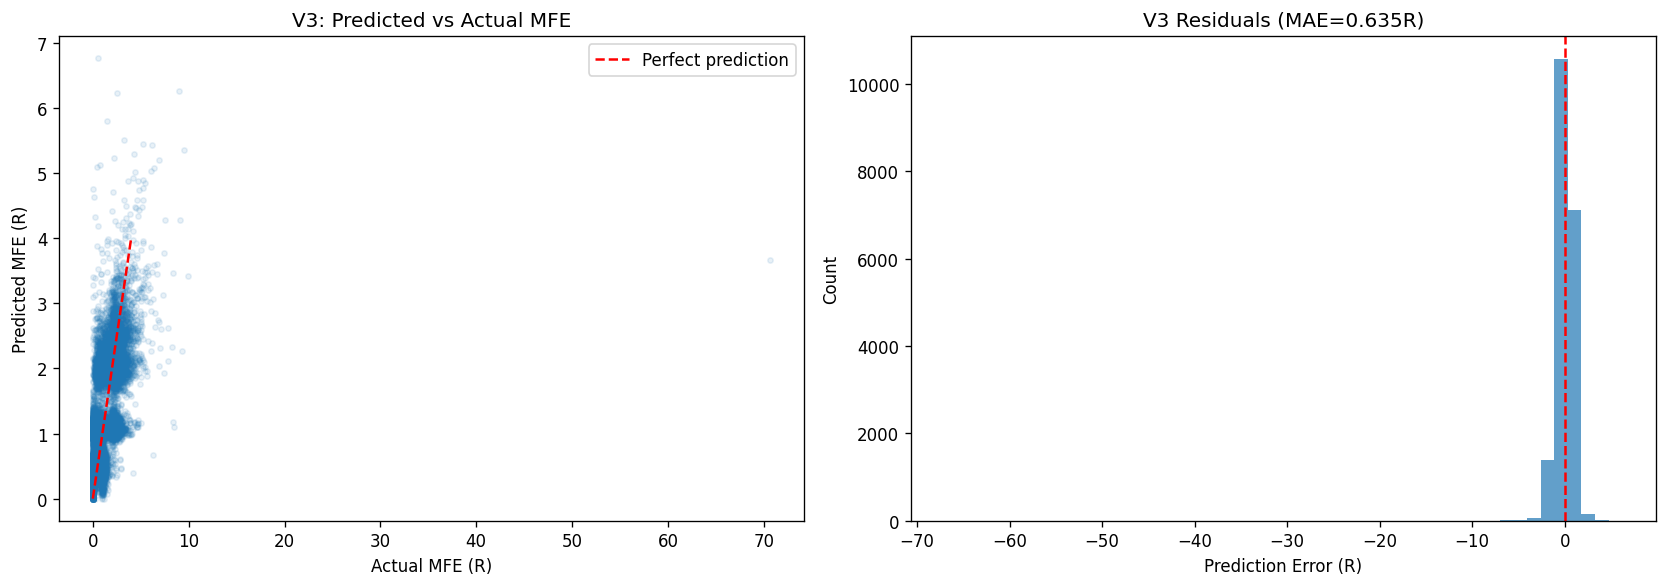


V3 Top 15 features:
  htf_d_close                              985.05
  pattern_type_false_breakout              529.56
  htf_d_bb_lower                           485.45
  htf_d_trend_state_strong_downtrend       424.80
  htf_d_macd_histogram                     424.41
  htf_d_rsi                                377.18
  dist_to_round_number_pips                289.67
  bb_upper                                 250.70
  trend_state_ranging                      220.49
  risk_reward_ratio                        194.45
  timeframe_D                              188.79
  htf_d_bb_upper                           187.82
  htf_h4_atr                               185.87
  htf_h4_trend_state_weak_downtrend        181.07
  pattern_type_pin_bar                     167.72


In [3]:
# Cell 3: V3 — MFE Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_v3 = xgb.XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    objective="reg:squarederror", eval_metric="rmse",
    random_state=42,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
)
model_v3.fit(X_train, y_v3_train)

y_v3_pred = model_v3.predict(X_test)
y_v3_pred = np.clip(y_v3_pred, 0, None)  # MFE can't be negative

mae = mean_absolute_error(y_v3_test, y_v3_pred)
rmse = np.sqrt(mean_squared_error(y_v3_test, y_v3_pred))
r2 = r2_score(y_v3_test, y_v3_pred)

print("=== V3 Regression Performance ===")
print(f"MAE:  {mae:.3f}R")
print(f"RMSE: {rmse:.3f}R")
print(f"R²:   {r2:.3f}")
print(f"\nBaseline MAE (predict mean): {np.abs(y_v3_test - y_v3_train.mean()).mean():.3f}R")

# Scatter: predicted vs actual MFE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(y_v3_test, y_v3_pred, alpha=0.1, s=10)
ax.plot([0, 4], [0, 4], "r--", label="Perfect prediction")
ax.set_xlabel("Actual MFE (R)")
ax.set_ylabel("Predicted MFE (R)")
ax.set_title("V3: Predicted vs Actual MFE")
ax.legend()

# Residual distribution
ax = axes[1]
residuals = y_v3_pred - y_v3_test
ax.hist(residuals, bins=50, alpha=0.7)
ax.axvline(x=0, color="red", linestyle="--")
ax.set_xlabel("Prediction Error (R)")
ax.set_ylabel("Count")
ax.set_title(f"V3 Residuals (MAE={mae:.3f}R)")

plt.tight_layout()
plt.show()

# Feature importance for V3
imp_v3 = model_v3.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame({"feature": imp_v3.keys(), "importance": imp_v3.values()}).sort_values("importance", ascending=False)
print(f"\nV3 Top 15 features:")
for _, row in imp_df.head(15).iterrows():
    print(f"  {row['feature']:40s} {row['importance']:.2f}")

=== Trading Simulation (Test Set) ===

Strategy A — V1b Fixed 2R (take all):
  Trades: 19313
  Wins: 7799 (40.4%)
  Total R: 4084.0R
  Avg R/trade: 0.211R

Strategy B — V2 Filtered (predicted >= 1R bucket):
  Trades: 11595 / 19313 (60.0% taken)
  Wins: 5367 (46.3%)
  Total R: 4506.0R
  Avg R/trade: 0.389R

Strategy C — V3 Dynamic TP (80% of predicted MFE):
  Trades: 19313
  Wins: 9348 (48.4%)
  Total R: 244.2R
  Avg R/trade: 0.013R
  Avg dynamic TP: 0.97R


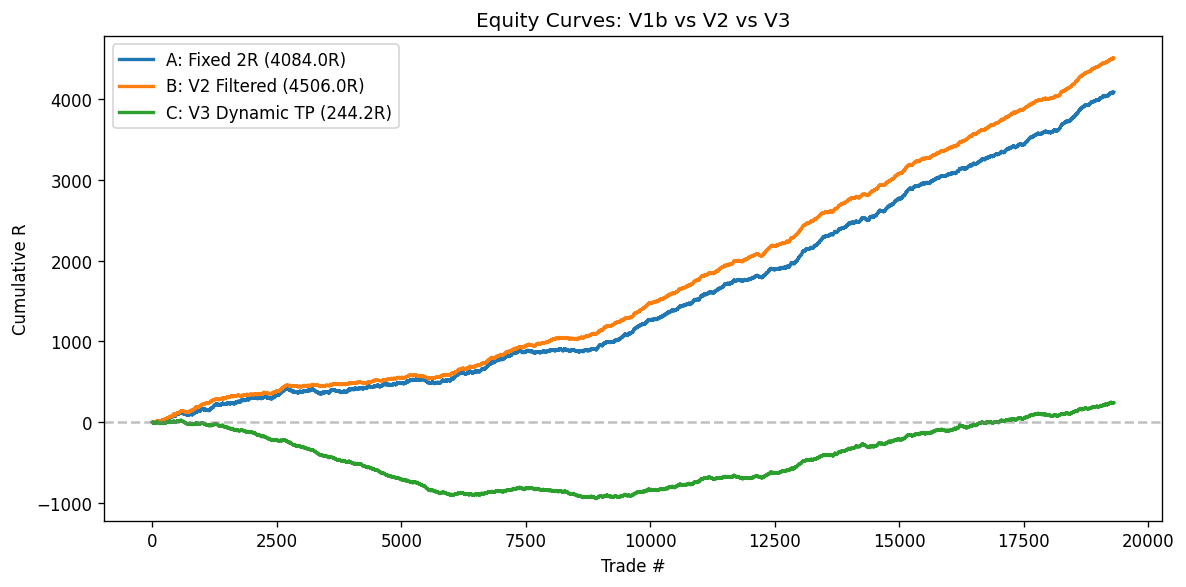

In [4]:
# Cell 4: Dynamic TP Trading Simulation
#
# For each test trade, simulate 3 strategies:
# A) V1b fixed 2R: take every trade, TP=2R → win=+2R, loss=-1R
# B) V2 filtered: only take trades predicted >= 1R bucket, TP=2R
# C) V3 dynamic TP: set TP at 80% of predicted MFE, clamped [0.5R, 3R]
#    Trade hits dynamic TP if actual MFE >= dynamic TP level

results = []

for i in range(len(X_test)):
    actual_mfe = mfe_test[i]
    actual_outcome = df_test.iloc[i]["outcome"]
    entry = df_test.iloc[i]["entry_price"]
    sl = df_test.iloc[i]["stop_loss"]
    risk = abs(entry - sl)
    
    # Strategy A: V1b fixed 2R
    pnl_a = 2.0 if actual_outcome == "win" else -1.0
    
    # Strategy B: V2 filtered (only take if predicted bucket >= 1R)
    v2_bucket = y_v2_pred[i]
    if v2_bucket >= 2:  # predicted 1-1.5R or higher
        pnl_b = 2.0 if actual_outcome == "win" else -1.0
        took_b = True
    else:
        pnl_b = 0.0
        took_b = False
    
    # Strategy C: V3 dynamic TP
    pred_mfe = y_v3_pred[i]
    dynamic_tp_r = np.clip(pred_mfe * 0.8, 0.5, 3.0)
    # Trade hits dynamic TP if actual MFE reached that level
    if actual_mfe >= dynamic_tp_r:
        pnl_c = dynamic_tp_r  # won at dynamic TP
    else:
        pnl_c = -1.0  # stopped out
    
    results.append({
        "actual_mfe": actual_mfe,
        "actual_outcome": actual_outcome,
        "pred_mfe": pred_mfe,
        "v2_bucket": v2_bucket,
        "dynamic_tp_r": dynamic_tp_r,
        "pnl_a": pnl_a,
        "pnl_b": pnl_b,
        "took_b": took_b,
        "pnl_c": pnl_c,
    })

sim = pd.DataFrame(results)

print("=== Trading Simulation (Test Set) ===")
print(f"\nStrategy A — V1b Fixed 2R (take all):")
print(f"  Trades: {len(sim)}")
print(f"  Wins: {(sim.pnl_a > 0).sum()} ({(sim.pnl_a > 0).mean():.1%})")
print(f"  Total R: {sim.pnl_a.sum():.1f}R")
print(f"  Avg R/trade: {sim.pnl_a.mean():.3f}R")

sim_b = sim[sim.took_b]
print(f"\nStrategy B — V2 Filtered (predicted >= 1R bucket):")
print(f"  Trades: {len(sim_b)} / {len(sim)} ({len(sim_b)/len(sim):.1%} taken)")
if len(sim_b) > 0:
    print(f"  Wins: {(sim_b.pnl_b > 0).sum()} ({(sim_b.pnl_b > 0).mean():.1%})")
    print(f"  Total R: {sim_b.pnl_b.sum():.1f}R")
    print(f"  Avg R/trade: {sim_b.pnl_b.mean():.3f}R")
else:
    print(f"  No trades taken")

print(f"\nStrategy C — V3 Dynamic TP (80% of predicted MFE):")
print(f"  Trades: {len(sim)}")
print(f"  Wins: {(sim.pnl_c > 0).sum()} ({(sim.pnl_c > 0).mean():.1%})")
print(f"  Total R: {sim.pnl_c.sum():.1f}R")
print(f"  Avg R/trade: {sim.pnl_c.mean():.3f}R")
print(f"  Avg dynamic TP: {sim.dynamic_tp_r.mean():.2f}R")

# Equity curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sim.pnl_a.cumsum().values, label=f"A: Fixed 2R ({sim.pnl_a.sum():.1f}R)", linewidth=2)
if len(sim_b) > 0:
    # Build B equity curve aligned to full index
    equity_b = sim.pnl_b.cumsum().values
    ax.plot(equity_b, label=f"B: V2 Filtered ({sim.pnl_b.sum():.1f}R)", linewidth=2)
ax.plot(sim.pnl_c.cumsum().values, label=f"C: V3 Dynamic TP ({sim.pnl_c.sum():.1f}R)", linewidth=2)
ax.set_xlabel("Trade #")
ax.set_ylabel("Cumulative R")
ax.set_title("Equity Curves: V1b vs V2 vs V3")
ax.legend()
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Model Comparison Dashboard

# V1b metrics
y_v1_pred = model_v1.predict(X_test)
y_v1_prob = model_v1.predict_proba(X_test)[:, 1]
v1_auc = roc_auc_score(y_v1_test, y_v1_prob)

# V2: use expected MFE from class probabilities as a continuous score
bucket_midpoints = np.array([0.25, 0.75, 1.25, 1.75, 2.5])
v2_expected_mfe = (y_v2_prob * bucket_midpoints).sum(axis=1)

print("=== Model Comparison ===")
print(f"{'Metric':<25s} {'V1b Binary':>12s} {'V2 Multi-R':>12s} {'V3 Regress':>12s}")
print("-" * 65)

# Trading metrics from simulation
print(f"{'Total R (test set)':<25s} {sim.pnl_a.sum():>12.1f} {sim.pnl_b.sum():>12.1f} {sim.pnl_c.sum():>12.1f}")
print(f"{'Avg R/trade':<25s} {sim.pnl_a.mean():>12.3f} {sim.pnl_b.mean() if len(sim_b) > 0 else 0:>12.3f} {sim.pnl_c.mean():>12.3f}")
win_rate_a = (sim.pnl_a > 0).mean()
win_rate_b = (sim_b.pnl_b > 0).mean() if len(sim_b) > 0 else 0
win_rate_c = (sim.pnl_c > 0).mean()
print(f"{'Win rate':<25s} {win_rate_a:>12.1%} {win_rate_b:>12.1%} {win_rate_c:>12.1%}")
trades_b = len(sim_b) if len(sim_b) > 0 else 0
print(f"{'Trades taken':<25s} {len(sim):>12d} {trades_b:>12d} {len(sim):>12d}")

# Statistical metrics
print(f"{'V1 AUC-ROC':<25s} {v1_auc:>12.3f} {'':>12s} {'':>12s}")
print(f"{'V2 Accuracy':<25s} {'':>12s} {accuracy_score(y_v2_test, y_v2_pred):>12.3f} {'':>12s}")
print(f"{'V3 MAE':<25s} {'':>12s} {'':>12s} {mae:>12.3f}")
print(f"{'V3 R²':<25s} {'':>12s} {'':>12s} {r2:>12.3f}")

# Max drawdown
def max_drawdown(pnl_series):
    cumulative = pnl_series.cumsum()
    running_max = cumulative.cummax()
    dd = cumulative - running_max
    return dd.min()

print(f"{'Max drawdown':<25s} {max_drawdown(sim.pnl_a):>12.1f}R {max_drawdown(sim.pnl_b):>12.1f}R {max_drawdown(sim.pnl_c):>12.1f}R")

=== Model Comparison ===
Metric                      V1b Binary   V2 Multi-R   V3 Regress
-----------------------------------------------------------------
Total R (test set)              4084.0       4506.0        244.2
Avg R/trade                      0.211        0.233        0.013
Win rate                         40.4%        46.3%        48.4%
Trades taken                     19313        11595        19313
V1 AUC-ROC                       0.704                          
V2 Accuracy                                   0.452             
V3 MAE                                                     0.635
V3 R²                                                      0.394
Max drawdown                     -67.0R        -49.0R       -970.4R


In [6]:
# Cell 6: Context Analysis — Where does V3 dynamic TP shine?

sim["pair"] = df_test["pair"].values
sim["pattern_type"] = df_test["pattern_type"].values
sim["trend_state"] = df_test["trend_state"].values
sim["timeframe"] = df_test["timeframe"].values

print("=== V3 Dynamic TP Performance by Context ===")

print("\n--- By Pair (top 10 by trade count) ---")
pair_stats = []
for pair in sorted(sim["pair"].unique()):
    sub = sim[sim["pair"] == pair]
    pair_stats.append((pair, len(sub), sub.pnl_a.sum(), sub.pnl_c.sum()))
pair_stats.sort(key=lambda x: x[1], reverse=True)
for pair, n, fixed, dynamic in pair_stats[:10]:
    print(f"  {pair:8s}  n={n:5d}  "
          f"fixed_2R={fixed:+.1f}R  "
          f"dynamic={dynamic:+.1f}R  "
          f"delta={dynamic - fixed:+.1f}R")

print("\n--- By Pattern ---")
for pt in sorted(sim["pattern_type"].unique()):
    sub = sim[sim["pattern_type"] == pt]
    print(f"  {pt:20s}  n={len(sub):5d}  "
          f"fixed_2R={sub.pnl_a.sum():+.1f}R  "
          f"dynamic={sub.pnl_c.sum():+.1f}R  "
          f"delta={sub.pnl_c.sum() - sub.pnl_a.sum():+.1f}R")

print("\n--- By Timeframe ---")
for tf in ["D", "H4", "H1", "M15"]:
    sub = sim[sim["timeframe"] == tf]
    if len(sub) == 0:
        continue
    print(f"  {tf:20s}  n={len(sub):5d}  "
          f"fixed_2R={sub.pnl_a.sum():+.1f}R  "
          f"dynamic={sub.pnl_c.sum():+.1f}R  "
          f"delta={sub.pnl_c.sum() - sub.pnl_a.sum():+.1f}R")

print("\n--- By Trend State ---")
for ts in sorted(sim["trend_state"].unique()):
    sub = sim[sim["trend_state"] == ts]
    if len(sub) < 20:
        continue
    print(f"  {ts:25s}  n={len(sub):5d}  "
          f"fixed_2R={sub.pnl_a.sum():+.1f}R  "
          f"dynamic={sub.pnl_c.sum():+.1f}R  "
          f"delta={sub.pnl_c.sum() - sub.pnl_a.sum():+.1f}R")

# Recovered trades
recovered = sim[(sim.pnl_a < 0) & (sim.pnl_c > 0)]
print(f"\n--- Recovered trades (fixed 2R lost, dynamic TP won) ---")
print(f"  Count: {len(recovered)} / {(sim.pnl_a < 0).sum()} losses ({len(recovered) / max((sim.pnl_a < 0).sum(), 1):.1%})")
if len(recovered) > 0:
    print(f"  Avg actual MFE: {recovered.actual_mfe.mean():.2f}R")
    print(f"  Avg dynamic TP: {recovered.dynamic_tp_r.mean():.2f}R")
    print(f"  Total R recovered: {recovered.pnl_c.sum() - recovered.pnl_a.sum():.1f}R")

=== V3 Dynamic TP Performance by Context ===

--- By Pair (top 10 by trade count) ---
  GBP/CHF   n= 1110  fixed_2R=+255.0R  dynamic=+72.0R  delta=-183.0R
  AUD/USD   n= 1108  fixed_2R=+260.0R  dynamic=+83.7R  delta=-176.3R
  USD/CAD   n= 1065  fixed_2R=+261.0R  dynamic=+80.4R  delta=-180.6R
  USD/JPY   n= 1040  fixed_2R=+202.0R  dynamic=+30.0R  delta=-172.0R
  EUR/CHF   n= 1014  fixed_2R=+180.0R  dynamic=-13.9R  delta=-193.9R
  CAD/JPY   n= 1013  fixed_2R=+292.0R  dynamic=+122.5R  delta=-169.5R
  EUR/JPY   n= 1008  fixed_2R=+288.0R  dynamic=+62.4R  delta=-225.6R
  NZD/USD   n=  991  fixed_2R=+344.0R  dynamic=+119.3R  delta=-224.7R
  EUR/AUD   n=  989  fixed_2R=+232.0R  dynamic=+78.2R  delta=-153.8R
  GBP/USD   n=  982  fixed_2R=+74.0R  dynamic=-103.2R  delta=-177.2R

--- By Pattern ---
  double_bottom         n= 3632  fixed_2R=+553.0R  dynamic=-1168.2R  delta=-1721.2R
  double_top            n= 4664  fixed_2R=-704.0R  dynamic=-2279.5R  delta=-1575.5R
  false_breakout        n= 5252  f

In [7]:
# Cell 7: Save Models & Summary
import os
import json

model_dir = "/Users/muftau/Documents/programming/trading-ai/python/models"
os.makedirs(model_dir, exist_ok=True)

model_v2.save_model(os.path.join(model_dir, "xgb_v2_multiclass.json"))
model_v3.save_model(os.path.join(model_dir, "xgb_v3_regression.json"))

meta = {
    "features": feature_cols,
    "n_features": len(feature_cols),
    "train_size": len(X_train),
    "test_size": len(X_test),
    "mfe_bucket_edges": bucket_edges[:-1] + [999],
    "mfe_bucket_labels": bucket_labels,
}

with open(os.path.join(model_dir, "xgb_v2v3_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Models saved:")
print(f"  V2: {model_dir}/xgb_v2_multiclass.json")
print(f"  V3: {model_dir}/xgb_v3_regression.json")
print(f"  Meta: {model_dir}/xgb_v2v3_meta.json")

print(f"\n=== Final Summary ===")
print(f"Dataset: {len(X)} rows ({len(X_train)} train / {len(X_test)} test)")
print(f"Features: {len(feature_cols)}")
print(f"\nV1b (binary):   AUC={v1_auc:.3f}, Total R={sim.pnl_a.sum():.1f}R")
print(f"V2  (multi-R):  Acc={accuracy_score(y_v2_test, y_v2_pred):.3f}, Total R={sim.pnl_b.sum():.1f}R")
print(f"V3  (regress):  MAE={mae:.3f}R, R²={r2:.3f}, Total R={sim.pnl_c.sum():.1f}R")
print(f"\nBest strategy by total R on test set: ", end="")
totals = {"V1b Fixed 2R": sim.pnl_a.sum(), "V2 Filtered": sim.pnl_b.sum(), "V3 Dynamic TP": sim.pnl_c.sum()}
best = max(totals, key=totals.get)
print(f"{best} ({totals[best]:+.1f}R)")

Models saved:
  V2: /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v2_multiclass.json
  V3: /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v3_regression.json
  Meta: /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v2v3_meta.json

=== Final Summary ===
Dataset: 96565 rows (77252 train / 19313 test)
Features: 104

V1b (binary):   AUC=0.704, Total R=4084.0R
V2  (multi-R):  Acc=0.452, Total R=4506.0R
V3  (regress):  MAE=0.635R, R²=0.394, Total R=244.2R

Best strategy by total R on test set: V2 Filtered (+4506.0R)
